Loda data

In [41]:
from DataLoader import HeartFailureDataset
import pandas as pd
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns

load_data = HeartFailureDataset()
X = load_data.get_features()
y = load_data.get_targets()

In [42]:
X = X.drop(columns=["time"])

In [43]:
from scipy.stats import zscore
import matplotlib.pyplot as plt
import numpy as np

z = zscore(X)
z_df = pd.DataFrame(z, columns=X.columns[:-1])
is_outlier = (np.abs(z_df) > 4).any(axis=1)
is_outlier
X = X[~is_outlier]
y = y[~is_outlier]

In [44]:
X['creatinine_phosphokinase'] = np.log(X['creatinine_phosphokinase']+1)
X['serum_creatinine'] = np.log(X['serum_creatinine'])

In [45]:
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = pd.DataFrame(scaler_X.fit_transform(X), columns=X.columns, index=X.index)
y = pd.DataFrame(scaler_y.fit_transform(y), columns=y.columns, index=y.index)

In [46]:
feature_names = X.columns

In [47]:
X = X.values
y = y.values.ravel()

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.special import softmax
import pandas as pd

def slog(X, tol=1e-300):
    """Safe log function (avoids underflow for small values)

    ### Parameters
    1. X : str
        - input you wish to take the log of

    ### Returns
    - log(X)
        - the log of the maximum between X and tol
    """
    return np.log(np.clip(X, a_min=tol, a_max=None))


In [49]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans


class eSPA_demo(BaseEstimator, ClassifierMixin):

    def __init__(self, K=3, epsC=1e-3, epsW=1e-2, max_iters=1000, tol=1e-10):
        self.K = K
        self.epsC = epsC
        self.epsW = epsW
        self.max_iters = max_iters
        self.tol = tol
        self._is_fitted = False
        
    def fit(self, X, y, N_anneal=32, criterion = "auc"):
        T, D = X.shape
        self.classes = np.unique(y)
        overall_K = self.K

        # Convert to one-hot
        Pi = np.zeros((T, len(self.classes)))
        for idx, c in enumerate(self.classes):
            Pi[y == c, idx] = 1

        best_crit = -np.inf
        best_model = {}

        for trial in range(N_anneal):
            # ----- Initialisierung ----- (diese ist zufällig, das ist der Punkt warum wir öfters fitten)
            self.K = overall_K
            rng = np.random.RandomState(trial)
            indices = rng.randint(0, T, self.K)
            C = X[indices, :]
            
            G = np.zeros((T, self.K))

            W = rng.rand(D) + 0.001
            W /= W.sum()

            L = rng.rand(len(self.classes), self.K)

            losses = []

            for i in range(self.max_iters):
                # Update G
                G = cdist(X, C, "sqeuclidean", w=W)
                G -= self.epsC * (np.matmul(Pi, slog(L)))
                mins = np.argmin(G, 1)
                G[:, :] = 0
                for m in np.unique(mins):
                    G[mins == m, m] = 1

                # Remove empty boxes
                emptyboxes = G.sum(0) == 0
                if any(emptyboxes):
                    G = G[:, ~emptyboxes]
                    C = C[~emptyboxes, :]
                    L = L[:, ~emptyboxes]
                    if G.shape[1] == 0:
                        break  # all clusters collapsed
                    self.K = G.shape[1]

                # Update W
                W[:] = 0
                for k in range(self.K):
                    W += np.sum(G[:, [k]] * ((X - C[[k], :]) ** 2), 0)
                W = softmax(-W / (T * self.epsW))

                # Update C
                C = (G.T @ X)
                C /= G.sum(0).reshape(-1, 1)

                # Update L
                L = Pi.T @ G
                sums = L.sum(0)
                sums[sums == 0] = 1
                L /= sums

                # Calculate loss
                Lval = (W * ((X - G @ C) ** 2).sum(0)).sum() / T
                Lval -= (self.epsC / T) * np.sum(Pi * (slog(L) @ G.T).T)
                Lval += self.epsW * np.dot(W, slog(W))
                losses.append(Lval)

                if i > 1 and abs(losses[-2] - losses[-1]) < self.tol:
                    break

            # ----- Simulated Annealing Auswahl -----
            # Nimm MOdell mit bester accuracy/roc auf den Trainingsdaten
            G_pred = cdist(X, C, "sqeuclidean", w=W)
            mins = np.argmin(G_pred, axis=1)
            G_pred[:, :] = 0
            for m in np.unique(mins):
                G_pred[mins == m, m] = 1
            probs = L @ G_pred.T
            preds = np.argmax(probs, axis=0)
            if criterion == "accuracy":
                acc = accuracy_score(y, preds)
                if acc > best_crit:
                    best_crit = acc
                    best_model = {
                        'W': W.copy(),
                        'C': C.copy(),
                        'G': G.copy(),
                        'L': L.copy(),
                        'losses': losses.copy(),
                        'iterations': i
                    }
            if criterion == "auc":
                auc_val = roc_auc_score(y, probs[1,:])
                if auc_val > best_crit:
                    best_crit = auc_val
                    best_model = {
                        'W': W.copy(),
                        'C': C.copy(),
                        'G': G.copy(),
                        'L': L.copy(),
                        'losses': losses.copy(),
                        'iterations': i
                    }
                


        # Setze bestes Modell
        self.W = best_model['W']
        self.C = best_model['C']
        self.G = best_model['G']
        self.L = best_model['L']
        self.losses = best_model['losses']
        self.iterations = best_model['iterations']
        self._is_fitted = True
        return self


    def predict_proba(self, X):
        G = cdist(X,self.C, "sqeuclidean", w=self.W)
        mins = np.argmin(G, 1)
        G[:,:] = 0
        for m in np.unique(mins):
            G[mins==m,m] = 1
        return self.L @ G.T #M times T matrix
        
    def predict(self, X):
        G = cdist(X, self.C, "sqeuclidean", w=self.W)
        mins = np.argmin(G, axis=1)
        G[:, :] = 0
        for m in np.unique(mins):
            G[mins == m, m] = 1
        probs = self.L @ G.T  # shape (num_classes, num_samples)
        preds = np.argmax(probs, axis=0)  # max Wahrscheinlichkeit pro Sample
        return preds

In [50]:
mod = eSPA_demo(K=6, epsC=1e-3, epsW=1e-2)
mod.fit(X,y, criterion = "auc")
predprob = mod.predict_proba(X)

score = roc_auc_score(y, predprob[1,:])
print(score)
mod.W

0.7908398707891093


array([7.03302743e-03, 1.50514360e-11, 8.59125648e-03, 1.63586700e-11,
       1.77502001e-01, 5.32970208e-01, 6.28244101e-02, 1.37648410e-01,
       7.34306872e-02, 1.82088685e-10, 2.86491819e-10])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import time


inner_cv = StratifiedKFold(n_splits=5)
param_grid = {
    'K': [3, 4, 5, 6, 7, 8],
    'epsC': [1, 1e-1, 1e-2, 1e-3],
    'epsW': [1e-1, 1e-2, 1e-3]
}


def my_grid_search(X, y, param_grid, inner_splits=5):
    skf = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=42)
    train_idx, test_idx = next(skf.split(X, y))  # Nur erster Fold

    keys = list(param_grid.keys())
    values = list(param_grid.values())
    from itertools import product
    param_combinations = list(product(*values))

    best_score = -np.inf
    best_params = None
    best_model = None

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    for comb in param_combinations:
        params = dict(zip(keys, comb))

        model = eSPA_demo(**params)
        model.fit(X_train, y_train, N_anneal = 100)
        proba = model.predict_proba(X_test)

        auc = roc_auc_score(y_test, proba[1,:])
        

        if auc > best_score:
            best_score = auc
            best_params = params
            best_model = model

    return best_params, best_score

def nested_cv(X, y, param_grid, outer_splits, inner_splits):
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=42)
    outer_scores = []
    outer_best_params = []
    best_w_values = []
    running_times = []

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):

        print(f"Outer Fold {fold_idx+1}/{outer_splits}")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        start_time = time.time()
        best_params, best_score = my_grid_search(X_train, y_train, param_grid, inner_splits=inner_splits)
        outer_best_params.append(best_params)

        print(f"Best params: {best_params}")
        model = eSPA_demo(**best_params)
        model.fit(X_train, y_train, N_anneal = 100)
        end_time = time.time()
        elapsed_time = end_time - start_time
        proba = model.predict_proba(X_test)

        auc = roc_auc_score(y_test, proba[1, :])
        print(f"AUC: {auc:.4f}")
        outer_scores.append(auc)

        best_w_values.append(model.W)
        running_times.append(elapsed_time)

    return outer_scores, outer_best_params, best_w_values, running_times

outer_scores, outer_best_params, best_w_values,running_times = nested_cv(X, y, param_grid, outer_splits=10, inner_splits=5)


Outer Fold 1/10
Best params: {'K': 8, 'epsC': 0.001, 'epsW': 0.001}
AUC: 0.6750
Outer Fold 2/10
Best params: {'K': 4, 'epsC': 1, 'epsW': 0.01}
AUC: 0.7944
Outer Fold 3/10
Best params: {'K': 3, 'epsC': 1, 'epsW': 0.1}
AUC: 0.8500
Outer Fold 4/10
Best params: {'K': 8, 'epsC': 0.001, 'epsW': 0.01}
AUC: 0.5806
Outer Fold 5/10
Best params: {'K': 7, 'epsC': 1, 'epsW': 0.01}
AUC: 0.8194
Outer Fold 6/10
Best params: {'K': 4, 'epsC': 0.01, 'epsW': 0.01}
AUC: 0.7836
Outer Fold 7/10
Best params: {'K': 7, 'epsC': 0.001, 'epsW': 0.01}
AUC: 0.8012
Outer Fold 8/10
Best params: {'K': 3, 'epsC': 1, 'epsW': 0.01}
AUC: 0.4327
Outer Fold 9/10
Best params: {'K': 6, 'epsC': 0.01, 'epsW': 0.01}
AUC: 0.5781
Outer Fold 10/10
Best params: {'K': 4, 'epsC': 0.001, 'epsW': 0.01}
AUC: 0.8000


In [54]:
grid_size = 1
for param_values in param_grid.values():
    grid_size *= len(param_values)

[0.6749999999999999, 0.7944444444444444, 0.85, 0.5805555555555556, 0.8194444444444444, 0.783625730994152, 0.8011695906432749, 0.4327485380116959, 0.578125, 0.8]


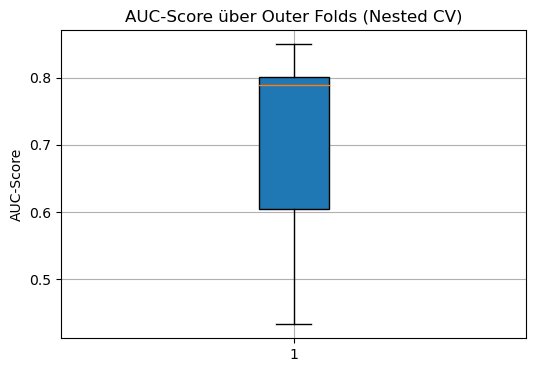

In [52]:
import matplotlib.pyplot as plt
print(outer_scores)
plt.figure(figsize=(6, 4))
plt.boxplot(outer_scores, vert=True, patch_artist=True)
plt.title('AUC-Score über Outer Folds (Nested CV)')
plt.ylabel('AUC-Score')
plt.grid(True)
plt.show()

In [58]:
model_evaluation = pd.DataFrame({"Fold": range(1, 11)})
model_evaluation['Modell'] = ['eSPA'] * 10
model_evaluation['ROC AUC'] = outer_scores
model_evaluation['runtime'] = [-1* r/grid_size for r in running_times]
model_evaluation

,Fold,Modell,ROC AUC,runtime
0,1,eSPA,0.675000,1.228842
1,2,eSPA,0.794444,1.145025
2,3,eSPA,0.850000,1.170004
3,4,eSPA,0.580556,1.107936
4,5,eSPA,0.819444,1.186091
5,6,eSPA,0.783626,0.986774
6,7,eSPA,0.801170,1.032184
7,8,eSPA,0.432749,1.050663
8,9,eSPA,0.578125,1.011043
9,10,eSPA,0.800000,1.221114


In [59]:
model_evaluation.to_pickle('model_evaluation/eSPA.pkl')

In [ ]:
ws = np.vstack(best_w_values)

In [ ]:
data = pd.DataFrame(ws, columns=feature_names)
df_melted = data.melt(var_name="Feature", value_name="w-value")

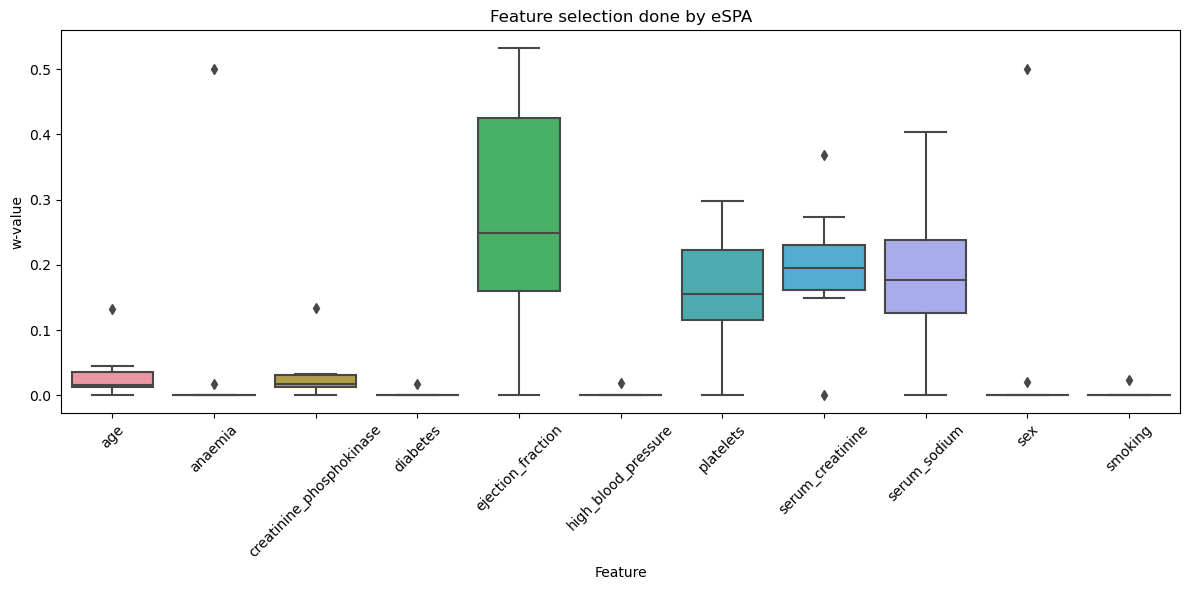

In [ ]:
# Seaborn Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x="Feature", y="w-value")
plt.title("Feature selection done by eSPA")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()